In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix

# Any results you write to the current directory are saved as output.


['sarcasam.csv', 'Sarcasm_Headlines_Dataset.json']


In [2]:
# pd.read_json('../input/Sarcasm_Headlines_Dataset.json', lines = True)

In [3]:
def parseJson(fname):
    for line in open(fname,'r'):
        yield eval(line)

In [4]:
file_name = '../input/Sarcasm_Headlines_Dataset.json'
data = list(parseJson(file_name))

In [5]:
df = pd.DataFrame(data)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
df = df.drop('article_link', axis= 1)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [7]:
df['len'] = df['headline'].apply(lambda x: len(x.split(" ")))
df.head()

,headline,is_sarcastic,len
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


In [8]:
df_length = df['len'].value_counts().reset_index()
df_length.rename(columns={'index': 'length_word', 'len':'frequency'}, inplace = True)
df_length.head()

,length_word,frequency
0,10,3484
1,9,3300
2,11,3196
3,8,2857
4,12,2646


<BarContainer object of 32 artists>

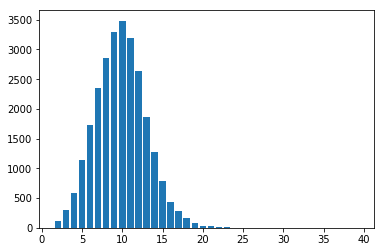

In [9]:
import matplotlib.pyplot as plt
plt.bar(df_length['length_word'], df_length['frequency'])

In [10]:
# removing those headline whose length is greather than 19
print('shape before preprocessing ',df.shape)
df = df[df['len'] < 19]
print('shape after preprocessing ',df.shape)
df.head()

shape before preprocessing  (26709, 3)
shape after preprocessing  (26526, 3)


,headline,is_sarcastic,len
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


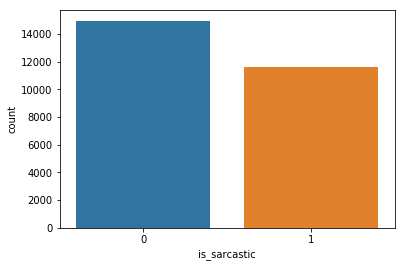

In [11]:
sns.countplot(df['is_sarcastic'])

In [12]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features= 5000)
X = tf.fit_transform(df['headline'])
y = df['is_sarcastic']


In [13]:
print(X)

  (0, 1558)	0.2960166175858903
  (0, 3987)	0.32338303053490264
  (0, 804)	0.39125461044789583
  (0, 4031)	0.37648561934518116
  (0, 3060)	0.22813765634992936
  (0, 3688)	0.3034427858544181
  (0, 514)	0.2549483324092845
  (0, 825)	0.3717039309418948
  (0, 1515)	0.14104688557816622
  (0, 2678)	0.38183109219319833
  (1, 1515)	0.1503011684990506
  (1, 4164)	0.13186158213863397
  (1, 708)	0.4100047602980481
  (1, 4618)	0.21655601795980775
  (1, 4339)	0.11015020634615844
  (1, 3043)	0.29259454410381597
  (1, 3211)	0.3266887081234713
  (1, 2716)	0.4169253712331714
  (1, 478)	0.3082450958087608
  (1, 229)	0.17754181516951112
  (1, 4932)	0.3663404743406768
  (1, 4627)	0.32555073148026725
  (2, 4339)	0.18225775504652708
  (2, 2703)	0.2319341808406505
  (2, 3950)	0.2952470152457354
  :	:
  (26520, 3222)	0.36961367783743404
  (26520, 1571)	0.4011543649530057
  (26520, 3223)	0.4037866670751614
  (26520, 4775)	0.4056110070093633
  (26521, 2019)	0.17823236872451775
  (26521, 215)	0.3525887232943081
 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [15]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
confusion_matrix(y_pred, y_test)

array([[3756,  564],
       [ 681, 2957]])

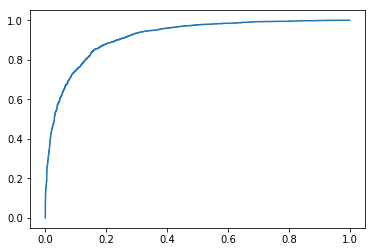

In [16]:
# Reciever opereating charactaristics (ROC)
proba = nb.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, proba)

auc_val = auc(fpr,tpr)
plt.plot(fpr, tpr)

In [17]:
f1_score(y_pred, y_test)

0.8260930297527588

In [18]:
## xgboost classifier
from xgboost import XGBClassifier
for i in range(10, 12):
    model = XGBClassifier(max_depth = i, n_jobs=4 )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f1_score(y_pred, y_test))

0.7738640827550085
0.775291192252323


In [19]:
# data cleaning


import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
# print ("punctuations that gonna be removed, : ",string.punctuation)
# print(stop_words)

def process(x):
    token_list = x.split()
#     print(token_list)
    new_list = [w.lower() for w in token_list if w not in string.punctuation]
    new_list = [w for w in new_list if w not in stop_words]
    new_list = [wordnet_lemmatizer.lemmatize(w) for w in new_list]
    return " ".join(new_list)

df['headline'] = df['headline'].apply(process)

   **Training model after removing noise  using Tfidvectorizer** 

In [20]:
# XGB after cleaning
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features= 5000, token_pattern="[a-zA-Z]{2,}", norm='l1')
X = tf.fit_transform(df['headline'])
y = df['is_sarcastic']
df.drop('len', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

for i in range(15, 20):
    model = XGBClassifier(max_depth = i, n_jobs = 8)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f1_score(y_pred, y_test))

0.5960982658959537
0.5994609164420485
0.6039692472733773
0.6069137562366357
0.6070344581324764


In [21]:
tf.get_feature_names()[:10]

['aaron',
 'abandoned',
 'abc',
 'ability',
 'able',
 'abortion',
 'abroad',
 'absence',
 'absolutely',
 'abuse']

In [22]:
#naive bayes after cleaning
nb = BernoulliNB(alpha=1)
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
f1_score(y_pred, y_test)

0.7483472895548701

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
f1_score(y_pred, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.669889502762431

** Training model after removing noise using CountVectorizer**

In [24]:
vec = CountVectorizer(ngram_range=(1,2), max_features=5000,  token_pattern="[a-zA-Z]{2,}")
X = vec.fit_transform(df['headline'])
y = df['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [25]:
nb = BernoulliNB(alpha=1)
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
f1_score(y_pred, y_test)

0.7614905031172974

In [26]:
from sklearn.linear_model import SGDClassifier

In [27]:
model = SGDClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score(y_pred, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.7389678384442783

In [28]:
from sklearn.svm import LinearSVC

In [29]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score(y_pred, y_test)

0.7375658279695729

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score(y_pred, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6809074837949323